# TEAM NAME: Classification Predict
## Introduction

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

### The task
With this context, we've been tasked with creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

### The benefit
The goal is to provide an accurate and robust solution that gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.

### Hypothesis
The target variable for this classification is the sentiment of a tweet based on the author's views regarding climate change.

We hypothesise that:
1. Denialists may use negative terms such `lies`, `exposed`, `conspiracy`, `fake` more frequently
2. Pro-climate change individuals use words such as `climate`, `global warming`, `earth`, `biosphere`, `global`, `fight`, `crisis`, `threat`, `denial` more often.
3. News media will mostly share URL links to full articles.

### Data and Library Imports
Now we will import the libraries required to perform:
* language manipulation
* data import, manipulation and visualisation

In [217]:
# Library imports

# running experiments
from comet_ml import Experiment
# Data manipulation and visualisation
import numpy as np # mathematical processing
import pandas as pd # data manipulation
import seaborn as sns # data visualisation
import matplotlib.pyplot as plt  # data visualisation
%matplotlib inline
# set plot style
sns.set()

# Text manipulation
import nltk # toolkit for language processing
from nltk.corpus import stopwords # redundant words
import re # regular expression for text extraction
import string # for punctuation removal
from nltk.tokenize import TreebankWordTokenizer # tokenizing words
from nltk import SnowballStemmer # stemming tool
from nltk import WordNetLemmatizer # lemmatizing tool
from sklearn.feature_extraction.text import CountVectorizer # create vectorised word counts
nltk.download('wordnet')

# model building
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

# model evaluation
from sklearn.metrics import accuracy_score


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Stanford\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Next we will import the `test` and `train` data provided. Thereafter we will inspect the first 5 rows of the train data to get an understanding of the data. 

In [3]:
# Data importation
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
# first 5 rows of train data
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [5]:
# first 5 rows of test data
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


#### Data Description
The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo. The datasets, consisting of `Train` and `Test` data aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were collected. The data was downloaded from: https://www.kaggle.com/c/edsa-climate-change-belief-analysis-2022/data

Each tweet is labelled as one of the following classes:

Class Description
* 2 News: the tweet links to factual news about climate change
* 1 Pro: the tweet supports the belief of man-made climate change
* 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change
* -1 Anti: the tweet does not believe in man-made climate change

Variable definitions
- sentiment: Sentiment of tweet
- message: Tweet body
- tweetid: Twitter unique id

Let's confirm that the sentiment values conform to the description above and next obtain a view of the data samples for each sentiment.

In [6]:
# identify the sentiment values
sentiment_labels = list(train.sentiment.unique())
print(sentiment_labels)

[1, 2, 0, -1]


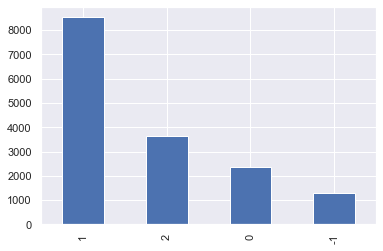

In [7]:
train['sentiment'].value_counts().plot(kind='bar')
plt.show()

From the bar graph above we discover that the majority of tweets are classified as pro the belief that climate change is man-made, followed by factual news, then neutral content and lastly tweets that show the believe that climate change is not man-made.

## Text Cleaning
Next we clean the message text to ensure that the data is in a usable format. First let's take a look at a message to see what kind of content we can expect to find. 

In [8]:
# Select the first tweet
train['message'].iloc[0]

"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable"

From the message above we observe that messages may contain web-urls, punctuation, upper and lower case characters.

### Removing Noise
Next we will remove unneccesary information, as seen above. These include web-urls, punctuation and stop-words. We will also convert the text to lower-case.

#### URL conversion

First we will replace website URLs with the text `url-web`

In [9]:
# Pattern to identify URLs
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
# Replacement text for URLs
subs_url = r'url-web'
# Replacement
train['message'] = train['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

#### Punctuation removal
Next we will ensure text uniformity by converting all text to lower case and then removing punctuation.

In [10]:
# Message text to lower case
train['message'] = train['message'].str.lower()

# Removing punctuation
print('Punctuation to be removed:', string.punctuation)

Punctuation to be removed: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [11]:
# Function to remove punctuation
def remove_punctuation(message):
    """this function removes punctuation from tweets"""
    return ''.join([l for l in message if l not in string.punctuation])

In [12]:
# Apply the remove_punctuation function
train['message'] = train['message'].apply(remove_punctuation)

Let's take another look at the first message to see the effect of the text clean up.

In [13]:
# Select the first tweet
train['message'].iloc[0]

'polyscimajor epa chief doesnt think carbon dioxide is main cause of global warming and wait what urlweb via mashable'

From the message above it's evident that all punctuation and unneccesary text has been removed. Next we will proceed with Feature Engineering.

**REMINDER** Check if any punctuation snuck through - standard encoding on text files in python

Next we will: 
* split message text into single words, known as tokens.
* apply stemming to the tokens to get to the root form of the word.

### Tokenisation

In [14]:
# Create tokenizer object
tokeniser = TreebankWordTokenizer()
# Tokenize words
train['tokens'] = train['message'].apply(tokeniser.tokenize)

Let's take another look at the first message to see the effect of tokenization.

In [15]:
print(train['tokens'].iloc[0])

['polyscimajor', 'epa', 'chief', 'doesnt', 'think', 'carbon', 'dioxide', 'is', 'main', 'cause', 'of', 'global', 'warming', 'and', 'wait', 'what', 'urlweb', 'via', 'mashable']


### Stemming
Next we will identify the root of each token created above.

In [16]:
# Create a Stemming object
stemmer = SnowballStemmer('english')

In [17]:
# Function to apply the stemmer to each word
def word_stemmer(message, stemmer):
    """the function applies the stemmer object to each
        word to return the stem of the word"""
    return [stemmer.stem(word) for word in message]

In [18]:
train['stem'] = train['tokens'].apply(word_stemmer, args=(stemmer, ))

Let's take another look at the first message to see the effect of stemming.

In [19]:
for i, t in enumerate(train.iloc[0]['tokens']):    
    print ('{:20s} --> {:10s}'.format(t, train.iloc[0]['stem'][i]))

polyscimajor         --> polyscimajor
epa                  --> epa       
chief                --> chief     
doesnt               --> doesnt    
think                --> think     
carbon               --> carbon    
dioxide              --> dioxid    
is                   --> is        
main                 --> main      
cause                --> caus      
of                   --> of        
global               --> global    
warming              --> warm      
and                  --> and       
wait                 --> wait      
what                 --> what      
urlweb               --> urlweb    
via                  --> via       
mashable             --> mashabl   


### Lemmatization
Next we will group words with similar meaning together using a process called lemmatization.

In [20]:
# Create a lemmatization object
lemmatizer = WordNetLemmatizer()

In [21]:
# Function to apply the lemmatization object to words
def message_lemma(message, lemmatizer):
    """ Lemmatize the tokens into words with similar meaning"""
    return [lemmatizer.lemmatize(word) for word in message]

In [22]:
# Apply the function to the tokens
train['lemma'] = train['tokens'].apply(message_lemma, args=(lemmatizer, ))

In [23]:
for i, t in enumerate(train.iloc[0]['tokens']):    
    print ('{:20s} --> {:10s}'.format(t, train.iloc[0]['lemma'][i]))

polyscimajor         --> polyscimajor
epa                  --> epa       
chief                --> chief     
doesnt               --> doesnt    
think                --> think     
carbon               --> carbon    
dioxide              --> dioxide   
is                   --> is        
main                 --> main      
cause                --> cause     
of                   --> of        
global               --> global    
warming              --> warming   
and                  --> and       
wait                 --> wait      
what                 --> what      
urlweb               --> urlweb    
via                  --> via       
mashable             --> mashable  


### Stop words
Next well remove all of the English stopwords from the message by first creating a removal function and then applying the function to the dataset.

In [24]:
def remove_stop_words(tokens):    
    return [t for t in tokens if t not in stopwords.words('english')]

In [25]:
train.head()

,sentiment,message,tweetid,tokens,stem,lemma
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,"[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,its not like we lack evidence of anthropogenic...,126103,"[its, not, like, we, lack, evidence, of, anthr...","[it, not, like, we, lack, evid, of, anthropoge...","[it, not, like, we, lack, evidence, of, anthro..."
2,2,rt rawstory researchers say we have three year...,698562,"[rt, rawstory, researchers, say, we, have, thr...","[rt, rawstori, research, say, we, have, three,...","[rt, rawstory, researcher, say, we, have, thre..."
3,1,todayinmaker wired 2016 was a pivotal year in...,573736,"[todayinmaker, wired, 2016, was, a, pivotal, y...","[todayinmak, wire, 2016, was, a, pivot, year, ...","[todayinmaker, wired, 2016, wa, a, pivotal, ye..."
4,1,rt soynoviodetodas its 2016 and a racist sexis...,466954,"[rt, soynoviodetodas, its, 2016, and, a, racis...","[rt, soynoviodetoda, it, 2016, and, a, racist,...","[rt, soynoviodetodas, it, 2016, and, a, racist..."


### Feature Engineering
Next we will drop the stop words from the messages and generate a few features, including:
* word frequecy (bag of words) - counts on word usage
* negative words - idetifying negation words 
* rare words - looking for rarest words used
* question - identify questions

Next we'll convert the message text to a dictionary, with the word as the key and its count as the value. 

#### Bag of words

In [26]:
# Function to create a bag of words
def bag_of_words_count(words, word_dict={}):
    """this function takes a list of words and returns a dictionary
        with each word as a key, and the value represents the number
        of times that word appeared."""
    for word in words:
        if word in word_dict.keys():
            word_dict[word] += 1
        else:
            word_dict[word] = 1
    return word_dict

Next we create a set of dictionaries, one for each of the sentiment types.

In [27]:
# sentiment dictionary creation
sentiment = {}
for s in sentiment_labels:
    df = train.groupby('sentiment')
    sentiment[s] = {}
    for row in df.get_group(s)['tokens']:
        sentiment[s] = bag_of_words_count(row, sentiment[s])

Next, we create a list of all the unique words.

In [28]:
all_words = set()
for s in sentiment_labels:
    for word in sentiment[s]:
        all_words.add(word)

Next, we will create a combined bag of words dictionary for all the words in the text.

In [29]:
sentiment['all'] = {}
for s in sentiment_labels:
    for word in all_words:
        if word in sentiment[s].keys():
            if word in sentiment['all']:
                sentiment['all'][word] += sentiment[s][word]
            else:
                sentiment['all'][word] = sentiment[s][word]

Next we will calculate the number of words in total.

In [30]:
total_words = sum([v for v in sentiment['all'].values()])
print('\nThere are', total_words, 'words in total')


There are 278214 words in total


Next, we will look at the distribution of words which occur less than 10 times in the whole dataset.

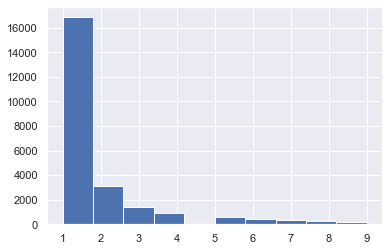

In [31]:
_ = plt.hist([v for v in sentiment['all'].values() if v < 10], bins=10)
plt.ylabel = ('# of words')
plt.xlabel = ('word frequency')

From the histogram above it appears a number of words appear only once. Let's get an exact count of those words.

In [32]:
# count of the number of words that appear once
once_count = len([v for v in sentiment['all'].values() if v == 1])
print('There are', once_count, 'words that appear only once.')

There are 16846 words that appear only once.


Next, we further investigate these words by printing them out to get a sense of the kind of words they are.

In [33]:
# list the words that appear once
rare_words = [k for k, v in sentiment['all'].items() if v == 1]
print('The following are the first 50 rare words:', end='\n\n')
print(rare_words[0:50])

The following are the first 50 rare words:

['paymenã¢â‚¬â¦', 'milford', 'prospects', '👍🏼', 'j3ff800', 'mdrache', 'waight4noone', 'distance', 'hvsthed', 'freespeech', 'ã°å¸â€œâ·exhibit', 'achalac', 'baptcarecommunity', 'climatology', 'heterosexual', 'postcardjohn', 'tabbyterry', 'pretence', 'andylassner', 'ditacannon', 'dharmadude', 'mrgates', 'facesofchange', 'residential', 'charlesornstein', 'channelsfeeddigestcomnewsidã¢â‚¬â¦', 'incredulous', 'someday', 'bikini', 'ostriches', 'jakevig', '£8', 'magsmcm', 'slapped', 'arc…', 'dairyisscary', 'woã¢â‚¬â¦', 'wildfires…', 'crocodile', 'multiscale', 'barbarism', 'urbancommunities', 'agchatoz', 'sarahwpoljanski', 'jszilagyi97', 'cathdweeb', 'ariberman', 'ssa', 'wont…', 'myvcrew']


Some of these words do not make sense. However before we remove them, let's establish how much these contribute to the total word count.

In [34]:
# count of the words appearing over 10 times
over_ten_count = len([v for v in sentiment['all'].values() if v >= 10])
print('There are', over_ten_count, 'words that appear over 10 times.', end='\n\n')

# total contribution count & percentage
over_ten_contribution = sum([v for v in sentiment['all'].values() if v >= 10])
print('These account for', over_ten_contribution, 'of the total words', end='' )
perc = over_ten_contribution / total_words
print('. This constitutes approximately', str(round(perc*100,)) + '%', 'of the total word count.')

There are 2494 words that appear over 10 times.

These account for 235570 of the total words. This constitutes approximately 85% of the total word count.


Therefor, we will remove roughly 15% of the words, as these are only used once.

In [35]:
# remove words that don't occur at least 10 times
max_count = 10
remaining_word_index = [k for k, v in sentiment['all'].items() if v > max_count]

### Hypothesis testing
Earlier we hypothesised that:
1. Denialists may use negative terms such `lies`, `exposed`, `conspiracy`, `fake` more frequently
2. Pro-climate change individuals may use words such as `climate`, `global warming`, `earth`, `biosphere`, `global`, `fight`, `crisis`, `threat`, `denial` more often.
3. News media will mostly share URL links to full articles.

Next we will validate the hypothesis by checking the most used terms per sentiment class. First we'll create one big dataframe with the word counts by sentiment class.

In [173]:
hm = []
for s, s_bow in sentiment.items():
    df_bow = pd.DataFrame([(k, v) for k, v in s_bow.items() if k in remaining_word_index], columns=['Word', s])
    df_bow.set_index('Word', inplace=True)
    hm.append(df_bow)
    
# create one big dataframe
df_bow = pd.concat(hm, axis=1)
df_bow.fillna(0, inplace=True)


Next we'll highlight the top 10 words used by pro-climate change tweet authors `sentiment class: 1`. FIrst we'll extract the `sentiment class: 1` from all the sentiments.

In [174]:
sentiment_types = [s for s in sentiment_labels if s == 1]

In [175]:
df_bow.head(5)

,1,2,0,-1,all
Word,,,,,
epa,268.0,240.0,29.0,16.0,553
chief,66.0,100.0,5.0,5.0,176
doesnt,718.0,21.0,53.0,20.0,812
think,234.0,16.0,81.0,29.0,360
carbon,96.0,78.0,12.0,15.0,201


Next we'll create total word count columns for each sentiment lable `(1,2,0,-1)`. 

Thereafter, we'll calculate the percentage contribution of each word specific to the sentiment column.

In [176]:
sentiment_types = [s for s in sentiment_labels if s == 1]

In [177]:
df_bow[1] = df_bow[sentiment_types].sum(axis=1)

In [179]:
for col in [1, 'all']:
    df_bow[str(col)+'_perc'] = df_bow[col] / df_bow[col].sum()

In [195]:
df_bow.sort_values(by='all', ascending=False).head(5)

,1,2,0,-1,all,1_perc,all_perc,chi2,-1_perc,chi2_-1
Word,,,,,,,,,,
climate,7346.0,3327.0,1437.0,787.0,12897,0.053632,0.055158,0.003895,0.040500,0.003895
change,6968.0,3139.0,1370.0,735.0,12212,0.050872,0.052228,0.003972,0.037824,0.003972
rt,5796.0,2151.0,1091.0,684.0,9722,0.042316,0.041579,0.000979,0.035200,0.000979
urlweb,3188.0,3627.0,754.0,459.0,8028,0.023275,0.034334,0.003343,0.023621,0.003343
the,4769.0,1129.0,946.0,844.0,7688,0.034818,0.032880,0.003387,0.043434,0.003387


In [181]:
# calculate chi2
df_bow['chi2'] = np.power((df_bow['1_perc'] - df_bow['all_perc']), 2) / df_bow['all_perc']

In [182]:
df_bow[['1_perc', 'all_perc', 'chi2']][df_bow['1_perc'] > df_bow['all_perc']].sort_values(by='chi2', ascending=False).head(10)

,1_perc,all_perc,chi2
Word,,,
shes,0.004570,0.002720,0.001259
believe,0.007308,0.004935,0.001141
doesnt,0.005242,0.003473,0.000901
we,0.008703,0.006441,0.000794
going,0.004307,0.002865,0.000726
die,0.002877,0.001788,0.000663
stephenschlegel,0.002241,0.001313,0.000656
husband,0.002278,0.001356,0.000627
thinking,0.002460,0.001510,0.000599


In [184]:
sentiment_types = [s for s in sentiment_labels if s == -1]

In [185]:
df_bow[-1] = df_bow[sentiment_types].sum(axis=1)

In [186]:
for col in [-1, 'all']:
    df_bow[str(col)+'_perc'] = df_bow[col] / df_bow[col].sum()

In [187]:
df_bow.sort_values(by='all', ascending=False).head(5)

,1,2,0,-1,all,1_perc,all_perc,chi2,-1_perc
Word,,,,,,,,,
climate,7346.0,3327.0,1437.0,787.0,12897,0.053632,0.055158,0.000042,0.040500
change,6968.0,3139.0,1370.0,735.0,12212,0.050872,0.052228,0.000035,0.037824
rt,5796.0,2151.0,1091.0,684.0,9722,0.042316,0.041579,0.000013,0.035200
urlweb,3188.0,3627.0,754.0,459.0,8028,0.023275,0.034334,0.003562,0.023621
the,4769.0,1129.0,946.0,844.0,7688,0.034818,0.032880,0.000114,0.043434


In [191]:
# calculate chi2
df_bow['chi2_-1'] = np.power((df_bow['-1_perc'] - df_bow['all_perc']), 2) / df_bow['all_perc']

In [192]:
df_bow[['-1_perc', 'all_perc', 'chi2_-1']][df_bow['1_perc'] > df_bow['all_perc']].sort_values(by='chi2_-1', ascending=False).head(10)

,-1_perc,all_perc,chi2_-1
Word,,,
realdonaldtrump,0.003602,0.001193,0.004864
is,0.027069,0.018677,0.003771
the,0.043434,0.032880,0.003387
concept,0.001338,0.000325,0.003157
manufacturing,0.001287,0.000308,0.003110
shes,0.000051,0.002720,0.002618
no,0.004323,0.002130,0.002258
created,0.001441,0.000462,0.002075
it,0.008131,0.005042,0.001892


In [211]:
#Generate word frequency
def gen_freq(text):
    #Will store the list of words
    word_list = []

    #Loop over all the tweets and extract words into word_list
    for tw_words in text.split():
        word_list.extend(tw_words)

    #Create word frequencies using word_list
    word_freq = pd.Series(word_list).value_counts()
    
    return word_freq

#Check whether a negation term is present in the text
def any_neg(words):
    for word in words:
        if word in ['n', 'no', 'non', 'not'] or re.search(r"\wn't", word):
            return 1
    else:
        return 0

#Check whether one of the 100 rare words is present in the text
def any_rare(words, rare_100):
    for word in words:
        if word in rare_100:
            return 1
    else:
        return 0

#Check whether prompt words are present
def is_question(words):
    for word in words:
        if word in ['when', 'what', 'how', 'why', 'who']:
            return 1
    else:
        return 0

In [213]:
word_freq = gen_freq(train.message.str)
#100 most rare words in the dataset
rare_100 = word_freq[-100:]

#Number of words in a tweet
train['word_count'] = train.message.str.split().apply(lambda x: len(x))

#Negation present or not
train['any_neg'] = train.message.str.split().apply(lambda x: any_neg(x))

#Prompt present or not
train['is_question'] = train.message.str.split().apply(lambda x: is_question(x))

#Any of the most 100 rare words present or not
train['any_rare'] = train.message.str.split().apply(lambda x: any_rare(x, rare_100))

#Character count of the tweet
train['char_count'] = train.message.apply(lambda x: len(x))

In [214]:
train.head()

,sentiment,message,tweetid,tokens,stem,lemma,word_count,any_neg,is_question,any_rare,char_count
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,"[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb...",19,0,1,0,116
1,1,its not like we lack evidence of anthropogenic...,126103,"[its, not, like, we, lack, evidence, of, anthr...","[it, not, like, we, lack, evid, of, anthropoge...","[it, not, like, we, lack, evidence, of, anthro...",10,1,0,0,61
2,2,rt rawstory researchers say we have three year...,698562,"[rt, rawstory, researchers, say, we, have, thr...","[rt, rawstori, research, say, we, have, three,...","[rt, rawstory, researcher, say, we, have, thre...",19,0,0,0,108
3,1,todayinmaker wired 2016 was a pivotal year in...,573736,"[todayinmaker, wired, 2016, was, a, pivotal, y...","[todayinmak, wire, 2016, was, a, pivot, year, ...","[todayinmaker, wired, 2016, wa, a, pivotal, ye...",14,0,0,0,79
4,1,rt soynoviodetodas its 2016 and a racist sexis...,466954,"[rt, soynoviodetodas, its, 2016, and, a, racis...","[rt, soynoviodetoda, it, 2016, and, a, racist,...","[rt, soynoviodetodas, it, 2016, and, a, racist...",18,0,0,0,114


In [206]:
"""# create a CountVectorizer object
vect = CountVectorizer(stop_words='english', 
                       ngram_range=(1, 2), 
                       max_df=0.5,
                       min_df=2)
vect.fit(train['message'])"""

"# create a CountVectorizer object\nvect = CountVectorizer(stop_words='english', \n                       ngram_range=(1, 2), \n                       max_df=0.5,\n                       min_df=2)\nvect.fit(train['message'])"

### Model building
Next we will train a Machine Learning model on the same. I will be using a Naive Bayes classifier from sklearn

#### Splitting the dataset into Train-Test split

 - The dataset is split into train and test sets so that we can evaluate our model's performance on unseen data.
 - The model will only be trained on the `train` set and will make predictions on the `test` set whose data points the model has never seen. This will make sure that we have a proper way to test the model.

In [218]:
# Splitting the dataset into Train-Test split
X = train[['word_count', 'any_neg', 'any_rare', 'char_count', 'is_question']]
y = train.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=27)

In [219]:
# Train the model

# initialise model object
model = GaussianNB()

# fit model to train dataset
model = model.fit(X_train, y_train)

# make a prediction
pred = model.predict(X_test)

### Model evaluation

In [221]:
# accuracy score
print('Accuracy:', round(accuracy_score(y_test, pred) * 100,), '%')

Accuracy: 56 %


In [36]:
# Create an experiment with your api key
experiment = Experiment(
    api_key="uSjPrOwXQdE1GLSEQuhuEJ1QQ",
    project_name="climate-change-sentiment",
    workspace="stanfordgibson",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/stanfordgibson/climate-change-sentiment/cb820c2894314681b057d04e8dbe8713

